In [24]:
import pandas as pd
import pymc as pm
import networkx as nx
import itertools as it
import math

from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore
from pgmpy.models import BayesianNetwork

from tqdm import tqdm
from itertools import combinations
from matplotlib import pyplot as plt

from timeit import default_timer as timer
from datetime import timedelta

from IPython.display import clear_output
%config InlineBackend.figure_format='retina'

# Create a Base Model

In [32]:
base_model = BayesianNetwork([('Smoking', 'Lung_Cancer'),
                            ('Genetics', 'Lung_Cancer'),
                            ('Genetics', 'Attention_Disorder'),
                            ('Smoking', 'Yellow_Fingers'),
                            ('Anxiety', 'Smoking'),
                            ('Peer_Pressure', 'Smoking'),
                            ('Allergy', 'Coughing'),
                            ('Lung_Cancer', 'Coughing'),
                            ('Coughing', 'Fatigue'),
                            ('Lung_Cancer', 'Fatigue'),
                            ('Fatigue', 'Car_Accident'),
                            ('Attention_Disorder', 'Car_Accident')])

base_model.add_node("Born_an_Even_Day")

# Learn with HillClimb

In [47]:
data = pd.read_csv('lucas0_1000.csv')
data

,Peer_Pressure,Anxiety,Lung_Cancer,Smoking,Born_an_Even_Day,Yellow_Fingers,Genetics,Allergy,Coughing,Car_Accident,Attention_Disorder,Fatigue
0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,0,0,1,1,0,1
2,0,1,1,1,1,1,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,1,1,0,1,0,0,1,1,0,1
996,0,1,1,1,1,1,0,0,1,1,0,1
997,0,0,0,0,1,0,0,0,0,1,1,0
998,0,1,1,1,0,1,0,1,1,1,0,1


In [48]:
start = timer()

scoring_method = BDeuScore(data=data)    
est = HillClimbSearch(data=data)
network = est.estimate(scoring_method=scoring_method, max_indegree=5, max_iter=int(1e4), show_progress=True)

end = timer()
elapsed_time = timedelta(seconds=end-start)
print(elapsed_time)

  0%|          | 0/10000 [00:00<?, ?it/s]

0:00:00.616571


# Plot

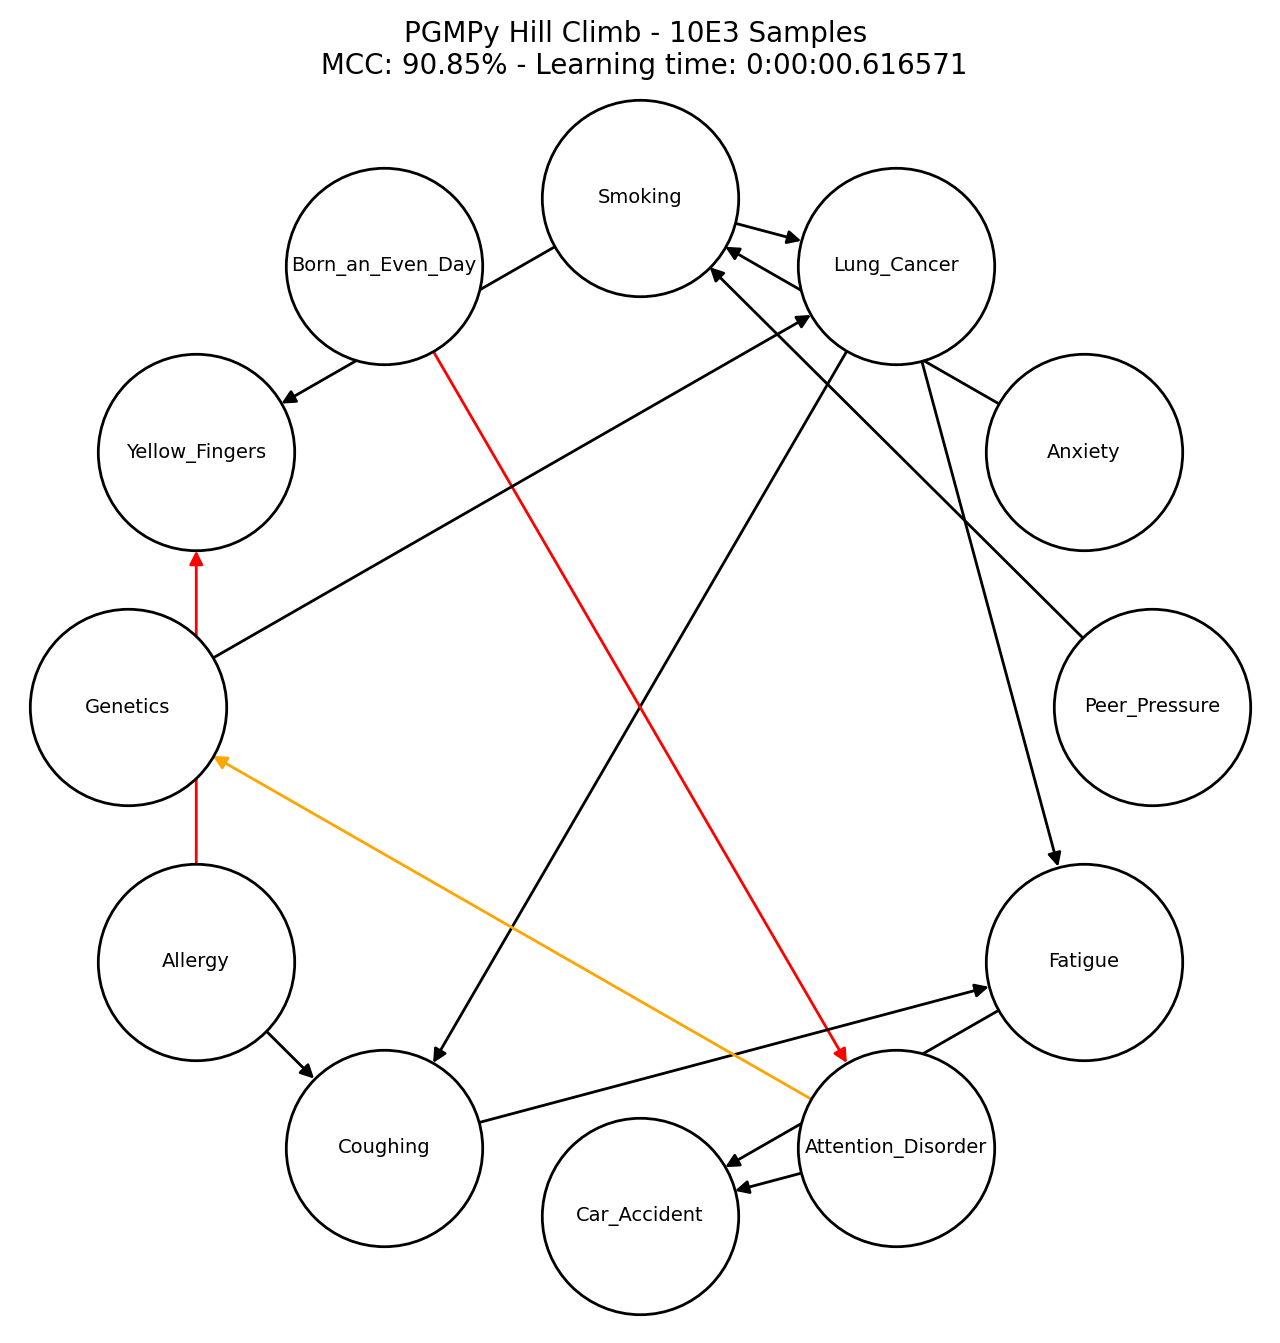

In [49]:
official_edges = base_model.edges()
node_names = list(data.columns)
SCENARIO_NAME = "PGMPy Hill Climb - 10E3 Samples"
bdeu = scoring_method
FP = []
FN = []
TP = []
TN = []

#evaluated_model = hc_model.edges()
evaluated_model = network.edges()

for v0,v1 in it.combinations(data.columns, 2):
    edge = (v0, v1)
    inverse_edge = (v1, v0)
    
    if edge in evaluated_model or inverse_edge in evaluated_model:
        if edge in official_edges or inverse_edge in official_edges:
            TP.append(edge)
            
        else:
            FP.append(edge)
    
    else:
        if edge in official_edges or inverse_edge in official_edges:
            FN.append(edge)
            
        else:
            TN.append(edge)
            
MCC = (len(TP) * len(TN)) - (len(FP)*len(FN))
MCC = MCC / math.sqrt((len(TP)+len(FP)) * (len(TP)+len(FN)) * (len(TN)+len(FP)) * (len(TN)+len(FN)))

digraph = nx.DiGraph()
digraph.add_nodes_from(node_names)

codes = list()
for edge in evaluated_model:
    if edge in official_edges:
        digraph.add_edge(edge[0], edge[1], color="black", style='-')
    elif (edge[1], edge[0]) in official_edges:
        digraph.add_edge(edge[0], edge[1], color="orange", style='-')
    else:    
        digraph.add_edge(edge[0], edge[1], color="red", style='-')

fig, ax = plt.subplots(1, 1, figsize=(8,8))
#ax.set_title(SCENARIO_NAME + " \n BDeu: "+ str(bdeu.score(digraph)), fontsize=7)
ax.set_title(SCENARIO_NAME + " \n MCC: "+ str(round(MCC*100, 2)) + "% - Learning time: " + str(elapsed_time), fontsize=10)

for edge in FN:
    digraph.add_edge(edge[0], edge[1], color="lightgrey", style='-')

edges_names = digraph.edges()
colors = [digraph[u][v]['color'] for u,v in edges_names]

# Custom the nodes:
nx.draw(digraph, with_labels=True, node_color='white', font_color='black', edgecolors='black', node_size=5000, width=1.0,
    pos=nx.circular_layout(digraph), edge_color=colors, ax=ax, font_size=7)